In [52]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import astropy.constants as c
import astropy.units as u
import scipy as sp
from astropy.modeling import models
from astropy.cosmology import Planck15 as cosmo

In [135]:
#In the below functions, t is the photon frequency shift factor and T is the temperature
def K(t,p):
    return -3*np.abs(1-t)/(32*p**6*t)*(1+(10+8*p**2 + 4*p**4)*t+t**2) + \
            (3*(1+t))/(8*p**5)*((3+3*p**2+p**4)/np.sqrt(1+p**2) - (3+2*p**2)/(2*p)*(2*np.arcsinh(p) -np.abs(np.log(t))))

def K_s(s, p):
    es = np.exp(s)
    return(K(es, p)*es)

def K_int(t, f, **kwargs):
    return integrate.quad(lambda p: f(p, **kwargs)*K(t,p), 0, np.inf)[0]


def _f_cr(p, alpha, p1, p2):
    if p1 < p < p2:
        return (alpha -1)*p**(-1*alpha)/(p1**(1-alpha)-p2**(1-alpha))
    else:
        return 0
    
f_cr = np.vectorize(_f_cr, excluded=['alpha','p1', 'p2'], otypes = [np.float]) 

def f_th(p,T):
    #'T' should be in units of eV
    try:
        T = T.to(u.eV)
    except:
        print('Error: T cannot be converted to eV')
        return
    beta_th = (c.m_e*c.c**2/T).value
    
    return beta_th/sp.special.kn(2,beta_th)*p**2*np.exp(-1*beta_th*np.sqrt(1+p**2))

def i(x):
    bb = models.BlackBody(temperature=cosmo.Tcmb0)
    try:
        nu = (x*c.k_B*cosmo.Tcmb0/c.h).to(u.GHz)
    except:
        print('Error: x cannot be converted to Hz')
        return
    
    return bb(nu)
    
#def j(x, f, **kwargs):
#    return integrate.quad(lambda t: i(x/t).value*K_int(t, f, **kwargs), 0, np.inf)

def j(x,f, **kwargs):
    return integrate.dblquad(lambda t, p: i(x/t).value*f(p, **kwargs)*K(t,p), 0, np.inf, lambda p: 0, lambda p: np.inf)


# Replicating fig 2 in Enslin 2000

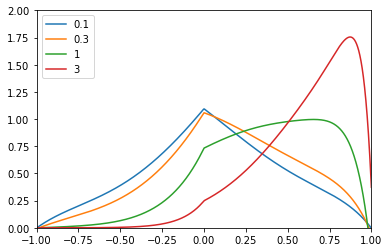

In [22]:
#This replicates the photon scattering probability function, called K(t,P) here and in zubair's paper and P in Enslin 2000
#The plot is of the log freq shift version but also validates K

s_space = np.linspace(-3.6,3.6,10000)
ps = [0.1, 0.3, 1, 3]
s_max_p = [0.2, 0.6, 1.8, 3.6]

for i, p in enumerate(ps):
    x = s_space/s_max_p[i]
    y = K_s(s_space, p)*s_max_p[i]
    plt.plot(x,y, label = str(p))
    
plt.xlim(-1,1)
plt.ylim(0, 2)
plt.legend()
plt.show()

In [46]:
K_int(2,f_cr, alpha=2.5, p1=1, p2=10000)

<ipython-input-45-48cbcf3af1cc>:10: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(lambda p: f(p, **kwargs)*K(t,p), 0, np.inf)[0]


-7.408000085810545e+60

# Electron momentum spectrum, non-thermal

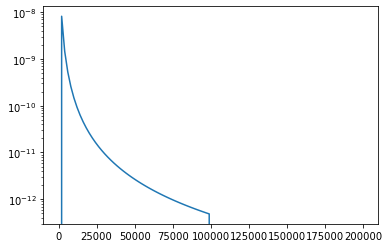

In [132]:
x = np.linspace(0,2e5, 100)
y = f_cr(x, alpha = 2.5, p1 = 1, p2 = 1e5)

plt.plot(x,y)
plt.yscale('log')
plt.show()


# Electron momentum spectrum, thermal

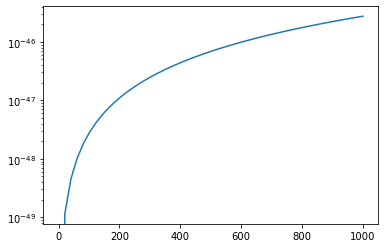

In [50]:
x = np.linspace(0,1e3)
y = f_th(x, 10000*u.eV)

plt.plot(x,y)
plt.yscale('log')
plt.show()

# Plankian dist

[5.67902054e-04 6.24697371e-03 1.19260454e-02 ... 5.67890696e+02
 5.67896375e+02 5.67902054e+02] GHz


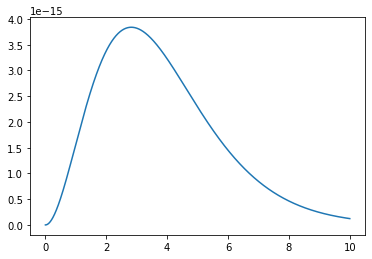

141.97551355157327 GHz


<Quantity 3.77351683e-15 erg / (cm2 Hz s sr)>

In [72]:
x = np.linspace(0.00001,10, 100000)
y = i(x)

plt.plot(x,y)
plt.show()
i(2.5)

# j(x) calculation

In [136]:
j(0.5284,f=f_cr, alpha=2.5, p1=1, p2=10000)

(-1.6798289994425922e-14, 2.274954590451889e-13)

In [137]:
j(0.5284,f=f_th, T=10000*u.eV)

(-6.793202846535409e-57, 2.2195220241901614e-54)

In [109]:
def myfunc(a, b):
    "Return a-b if a>b, otherwise return a+b"
    if a > b:
        return a - b
    else:
        return a + b
vfunc = np.vectorize(myfunc)
vfunc([1, 2, 3, 4], 2)


array([3, 4, 1, 2])